## Libraries

In [1]:
from keras.layers import TextVectorization
import re
import string
import tensorflow as tf
import os
import pathlib
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


## Config

In [2]:
DATASET_PATH ="C:/Users/Tajr/Desktop/textlab/datasets/"
OUTPUT_PATH = "C:/Users/Tajr/Desktop/textlab/outputs/"
MODEL_PATH = os.path.join(OUTPUT_PATH, 'model/')
IMDB_REVIEWS_PATH = os.path.join(DATASET_PATH, os.listdir(DATASET_PATH)[0])
IMDB_DENSE_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_dense/')
IMDB_LSTM_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_lstm/')
BATCH_SIZE = 32
MAX_TOKENS = 20000
MULTIPLE_CPU = 5
EPOCHS = 10

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/Tajr/Desktop/UDSM/Experiments/datasets/'

## Utils

In [ ]:
def get_val_samples():
    base_dir = pathlib.Path(IMDB_REVIEWS_PATH)
    val_dir = base_dir / "val"
    train_dir = base_dir / "train"

    for category in ("neg", "pos"):
        os.makedirs(val_dir / category)
        files = os.listdir(train_dir / category)
        random.Random(1337).shuffle(files)
        num_val_samples = int(0.2 * len(files))
        val_files = files[-num_val_samples:]

        for fname in val_files:
            shutil.move(train_dir / category / fname, val_dir / category / fname)
            
# Accessing data
def inspect_dataset(dataset):
    for inputs, targets in dataset:
        print('inputs.shape: ', inputs.shape)
        print('inputs.dtype: ', inputs.dtype)
        print('targets.shape: ', targets.shape)
        print('targets.dtype: ', targets.dtype)
        print()
        print('Label: {}'.format(targets[0]))
        print('Sample: {}'.format(inputs[0]))
        break

# define and compile your model     
def get_model(max_tokens=MAX_TOKENS, hidden_dim=16):
    # define inputs, hidden layers, and output layer
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # define model
    model = keras.Model(inputs, outputs)
    
    # compile your model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # return your model
    return model

# check if output dir exist, if not create it
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Visualize training process
def plot_loss_accuracy(history, file_path):
    # set style
    mkdir(file_path)
    plt.style.use('ggplot')
    (fig, axs) = plt.subplots(2, 1)
    axs[0].plot(history['loss'], label='Training Loss')    
    axs[0].plot(history['val_loss'], label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()    
    axs[1].plot(history['accuracy'], label='Training Accuracy') 
    axs[1].plot(history['val_accuracy'], label='Validation Accuracy')    
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    fig.savefig(file_path)
    plt.show()

## Dataset

Sequential data - any data where the order or sequency is as essential as the data itself. example sentences, stock market data, audio data etc


### Raw data

In [ ]:
# These dataset yield inputs that are Tensorflow tf.string tensors and 
# targets are int 32 tensors encoding the value 0 and 1
train_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'train'), batch_size=BATCH_SIZE)
val_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'val'), batch_size=BATCH_SIZE)
test_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'test'), batch_size=BATCH_SIZE)

In [ ]:
# Accessing data
for i, line in enumerate(train_dataset.take(1)):
    print('Label: {}'.format(line[1][2]))
    print('Sample: {}'.format(line[0][2]))
  

In [ ]:
inspect_dataset(train_dataset)

## Data Processing

### Standardization, Tokenization and Vectorization

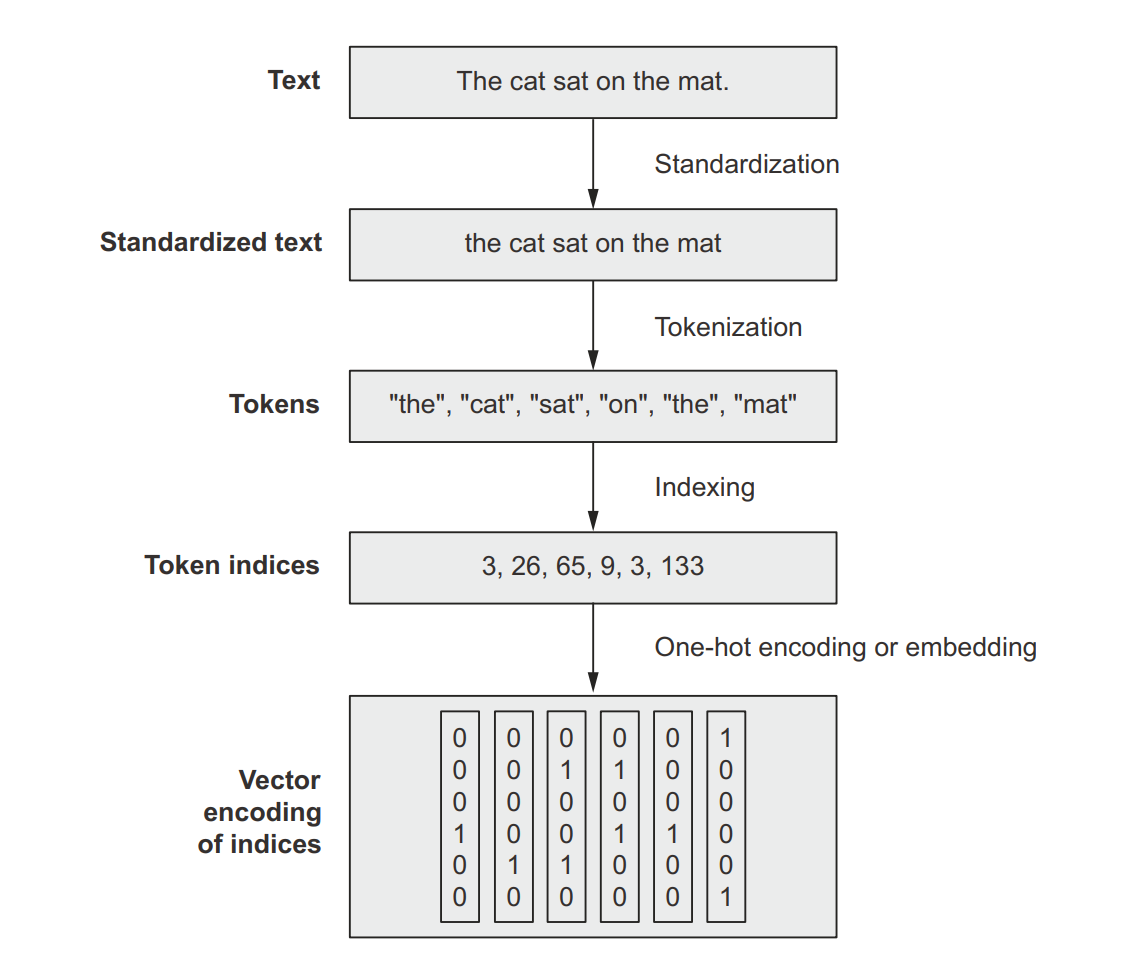

## BAG OF WORDS APPROACH (WORD AS A SET)
- Individual Words(Unigram)
- Group of consecutive tokens(N-grams)

##### Unigram with Binary Encoding

In practice you will use TextVectorization layer which is efficient and fast way of doing things.
- By defauld the layer will use the setting to convert to lowercase and remove punctuation (Standardizaztion), Split on whitespace (tokenization)
- It can receive custom function for standardization and tokenization
- Call adapt method to index the vocabulary of a text corpus

In [ ]:
# define vectorizer
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_mode='multi_hot')

In [ ]:
# prepare a dataset that only yields raw text inputs no labels
text_only_train_ds = train_dataset.map(lambda x, y: x)

# use the dataset to index the dataset vocabulary via the adapt() method
vectorizer.adapt(text_only_train_ds)

In [ ]:
# prepare the processed versions of our training validation and test dataset
train_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
val_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
test_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [ ]:
inspect_dataset(train_ds)

In [ ]:
inspect_dataset(val_ds)

In [ ]:
inspect_dataset(test_ds)

##### Bigrams

###### standardization, tokenization and vectorization

In [ ]:
# prepare a dataset that only yield raw text inputs no labels
text_only_train_dataset = train_dataset.map(lambda x, y: x)

# use the dataset to index the dataset vocabulary via the adapt() method
vectorizer = TextVectorization(ngrams=2, max_tokens=MAX_TOKENS, output_mode='multi_hot')
vectorizer.adapt(text_only_train_dataset)

In [ ]:
# create datasets
btrain_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
bval_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
btest_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [ ]:
# inspect dataset
inspect_dataset(btrain_ds)

##### Term Frequency, Inverse Document Frequency (TF-IDF)
- it weights a given term by taking term frequency, how many times the term appear in the current document and divide it by a measure of document frequency, which estimates how often the term comes up across the dataset

###### standardization, tokenization and vectorization

In [ ]:
# get input text without labels
text_only_train_dataset = train_dataset.map(lambda x, y: x)

# vectorize with tf-idf
vectorizer = TextVectorization(ngrams=2, max_tokens=MAX_TOKENS, output_mode='tf_idf')
vectorizer.adapt(text_only_train_dataset)

In [ ]:
# create datasets
tf_train = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
tf_val = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
tf_test = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [ ]:
# inspect dataset
inspect_dataset(tf_train)

## MODEL

In [ ]:
# define and compile your model
model = get_model()

# get model summary
model.summary()

### Model Training (Unigram)

In [ ]:
# define callbacks if any
callbacks = [
    keras.callbacks.ModelCheckpoint('binary_1gram.keras', save_best_only=True)
]

In [ ]:
# fit or train your model with given datasets
history_dense = model.fit(train_ds.cache(), validation_data=val_ds.cache(), epochs=EPOCHS, callbacks=callbacks)

#### Evaluation

In [ ]:
model = keras.models.load_model('binary_1gram.keras')

In [ ]:
print(f"Test acc: {model.evaluate(test_ds)[1]:.3f}")

In [ ]:
df = pd.DataFrame(data=history_dense.history)
df.describe()

In [ ]:
plot_loss_accuracy(history_dense.history,IMDB_DENSE_OUTPUT)

### Model Training (Bigram)

In [ ]:
bigram_model = get_model()
bigram_model.summary()

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('bigram_model.keras', save_best_only=True)]

In [ ]:
history_bigram_dense = bigram_model.fit(btrain_ds.cache(), validation_data=bval_ds, callbacks=callbacks, epochs=EPOCHS)

#### Evaluation

#### Testing

In [ ]:
model = keras.models.load_model('bigram_model.keras')
print(f"Test acc: {model.evaluate(btest_ds)[1]:.3f}")

#### Visualization

In [ ]:
df = pd.DataFrame(data=history_bigram_dense.history)
df.describe()

In [ ]:
plot_loss_accuracy(history_bigram_dense.history,IMDB_DENSE_OUTPUT)

with bigram, hence local order is pretty important

### Model Training (TF-IDF)

In [ ]:
# get model
tf_model = get_model()
tf_model.summary()

In [ ]:
# callbacks
callbacks = [keras.callbacks.ModelCheckpoint('tf_model.keras', save_best_only=True)]

# train
tf_history = model.fit(tf_train.cache(), validation_data=tf_val.cache(), epochs=EPOCHS, callbacks=callbacks)

### Evaluation

In [ ]:
model = keras.models.load_model('tf_model.keras')
print(f'Test accuracy: {model.evaluate(tf_test)[1]:.3f}')

In [ ]:
df = pd.DataFrame(data=tf_history.history)
df.describe()

### Visualization

In [ ]:
plot_loss_accuracy(tf_history.history,IMDB_DENSE_OUTPUT)

## Exporting a Model that process raw strings

## Inferencing

## THE SEQUENCE MODEL APPROACH  (WORDS AS A SEQUENCE)


### Config

In [ ]:
# In order to keep a managable input size, we will truncate the inputs after the first 600 words
# this is a reasonable choice, since the average review length is 233 words, and only 5% of 
# reviews are longer than 600 words
MAX_LENGTH = 600

### Sequence data processiong

In [ ]:
# Standardization, tokenization and vectorization
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_mode='int', output_sequence_length=MAX_LENGTH)
vectorizer.adapt(text_only_train_dataset)

train_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
val_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
test_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [ ]:
inspect_dataset(train_ds)

### MODEL

In [ ]:
def get_lstm(max_tokens=MAX_TOKENS, hidden_dim=32):
    # define
    inputs = keras.Input(shape=(None,), dtype='int64')
    embedded = tf.one_hot(inputs, depth=max_tokens) # encode the intergers into binary 20000 dimension vector
    x = layers.Bidirectional(layers.LSTM(hidden_dim))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    
    # compile
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # return
    return model

In [ ]:
model = get_lstm()
model.summary()

### Train

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('one_hot_bidir_lstm.keras', save_best_only=True)]
history_lstm = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

### Evaluation

In [ ]:
# read train history
df = pd.DataFrame(history_lstm.history)
df.describe()

In [ ]:
# load your model
model = keras.models.load_model('one_hot_bidir_lstm.keras')
model.summary()

In [ ]:
# run a test
print(f'{model.evaluate(test_ds)[1]:.3f}')

### Visualization

In [ ]:
plot_loss_accuracy(history_lstm.history, IMDB_LSTM_OUTPUT)